In [1]:
import numpy as np
import random
from CompilerQC import Graph
from CompilerQC import core
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint
from CompilerQC import Polygons
from CompilerQC import Energy
from CompilerQC import MC
from scipy.special import binom
import networkx as nx
from networkx import bipartite

In [138]:
N = 8
graph = Graph.complete(N)

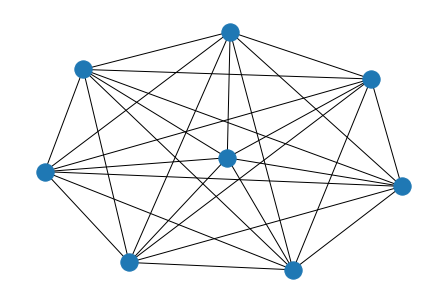

In [139]:
nx.draw(graph.to_nx_graph())

In [140]:
graph.C, graph.K

(21, 28)

In [141]:
from networkx.algorithms.isomorphism import GraphMatcher

def bf_find_all_bipartite_graphs(graph):
    """
    find all complete bipartite graphs in graph 
    by generating a bipartite graph of size i,j and 
    searching for it via the subgraph isomorphism 
    this if the brute force method for finding the 
    bipartite graphs
    """
    list_of_UV = []
    for i in range(2, N):
        for j in range(2, N):
            print(i,j, end='')
            S = core.complete_bipartite_graph(i, j)
            G = graph.to_nx_graph()
            K_nn = S
            GM = GraphMatcher(G, S)
            for m in GM.subgraph_monomorphisms_iter():
                reversed_mapping = {v: k for k, v in m.items()}
                K_nn = nx.relabel_nodes(S, reversed_mapping)
                # parts of bipartite graph
                U, V = bipartite.sets(K_nn)
                U, V = list(U), list(V)
                list_of_UV.append([U,V])
    return list_of_UV



In [142]:
list_of_UV = bf_find_all_bipartite_graphs(graph)
len(list_of_UV)

2 22 32 42 52 62 73 23 33 43 53 63 74 24 34 44 54 64 75 25 35 45 55 65 76 26 36 46 56 66 77 27 37 47 57 67 7

438480

In [143]:
# def bf_find_several_bipartite_graphs(graph):
#     """
#     find all complete bipartite graphs in graph 
#     by generating a bipartite graph of size i,j and 
#     searching for it via the subgraph isomorphism 
#     """
#     list_of_UV = []
#     for i in range(2, N):
#         for j in range(2, N):
#             print(i,j, end='')
#             S = core.complete_bipartite_graph(i, j)
#             if core.subgraph_is_monomorphic(graph.to_nx_graph(), S):
#                 UV = core.parts_of_complete_bipartite_graph(graph.to_nx_graph(), S)
#                 list_of_UV.append(UV)
#     return list_of_UV
# list_of_UV = bf_find_several_bipartite_graphs(graph)
# len(list_of_UV)

In [144]:
# sort sets UV, smaller set first
sort_UV_by_len = [sorted(uv, key=len) for uv in list_of_UV] 
# remove double sets as [U, V] and [V, U]
dropped_duplicates_in_UV = []
for uv in sort_UV_by_len:
    if (
        [uv[0], uv[1]] not in dropped_duplicates_in_UV 
        and [uv[1], uv[0]] not in dropped_duplicates_in_UV
    ):
        dropped_duplicates_in_UV.append(uv)
dropped_duplicates_in_UV = np.array(dropped_duplicates_in_UV, dtype=object)
len(dropped_duplicates_in_UV)

2037

In [145]:
# remove [U', V'] if it is already part in a larger [U, V]
Us = np.array(dropped_duplicates_in_UV, dtype=object)[:,0]
Vs = np.array(dropped_duplicates_in_UV, dtype=object)[:,1]
setUs = list(map(set, Us))
setVs = list(map(set, Vs))
is_subsetu_u = np.array([[u_.issubset(u) for u in setUs] for u_ in setUs])
is_subsetu_v = np.array([[u_.issubset(v) for v in setVs] for u_ in setUs])
is_subsetv_u = np.array([[v_.issubset(u) for u in setUs] for v_ in setVs])
is_subsetv_v = np.array([[v_.issubset(v) for v in setVs] for v_ in setVs])

v_in_UV = np.logical_or(is_subsetv_u, is_subsetv_v)
u_in_UV = np.logical_or(is_subsetu_u, is_subsetu_v)
uv_already_in_UV = np.logical_and(v_in_UV, u_in_UV)
uv_already_in_UV = np.sum(uv_already_in_UV, axis=-1) > 1
unique_lists_of_UV = dropped_duplicates_in_UV[~uv_already_in_UV]
len(unique_lists_of_UV)

119

In [146]:
def get_sets_from_UV(list_of_UVs):  
    array_of_UVs = np.array(list_of_UVs, dtype=object)
    set_of_UVs = np.apply_along_axis(lambda x:[set(i) for i in x], -1, array_of_UVs)
    return set_of_UVs

In [147]:
# make U, V to sets
unique_sets_of_UV = get_sets_from_UV(unique_lists_of_UV)

In [148]:
Us, Vs = unique_sets_of_UV.T

In [149]:
# seed longest rectengulat
max_v = max(Vs, key=len)
max_u = Us[np.where(Vs == max_v)][0]
already_in_max = [np.where(Vs == max_v)[0][0]]
max_u, max_v

({0, 2}, {1, 3, 4, 5, 6, 7})

In [150]:
# seed max(n * m)
mn = list(map(lambda uv: len(uv[0]) * len(uv[1]), unique_sets_of_UV))
max_idx = mn.index(max(mn))
max_v = Vs[max_idx]
max_u = Us[max_idx]
already_in_max = [max_idx]
max_u, max_v

({0, 2, 3, 4}, {1, 5, 6, 7})

In [151]:

def sort_unique_sets_of_UV(b: 'unique_sets_of_UV'):
    global max_u, max_v, already_in_max
    print(max_u, max_v)
    b = get_sets_from_UV([sorted(l, key=lambda x: len(set(x).intersection(max_v)) / len(x) ) for l in b])
    intersection_v_max_v = np.array(list(map(lambda uv: 10 if uv[1] == max_v else len(uv[1].intersection(max_v)) / len(max_v), b)))
    intersection_u_max_v = np.array(list(map(lambda uv: 10 if uv[0] == max_v else len(uv[0].intersection(max_v)) / len(max_v), b)))
    intersection_v_max_u = np.array(list(map(lambda uv: 10 if uv[1] == max_u else len(uv[1].intersection(max_u)) / len(max_u), b)))
    intersection_u_max_u = np.array(list(map(lambda uv: 10 if uv[0] == max_u else len(uv[0].intersection(max_u)) / len(max_u), b)))
    fr = list(intersection_u_max_u - intersection_v_max_u)
    fr = list(reversed(np.argsort(fr)))
    idx = [i for i in fr if i not in already_in_max][0]
    already_in_max.append(idx)
    if b[idx][1].intersection(max_u) > b[idx][0].intersection(max_u):
        b[idx][1], b[idx][0] = b[idx][0], b[idx][1]
    max_u  = set.union(b[idx][0], max_u)
    max_v = set.union(b[idx][1], max_v)
    b_old = b[:]
    b = get_sets_from_UV([sorted(l, key=lambda x: len(set(x).intersection(max_u)) / len(x), reverse=True) for l in b])
    if (b == b_old).all():
        print('found',b)
        return b
    else:
        print('once more')
        return sort_unique_sets_of_UV(b)


In [152]:
# sort U, V by seed
UVs = sort_unique_sets_of_UV(unique_sets_of_UV)

{0, 2, 3, 4} {1, 5, 6, 7}
once more
{0, 2, 3, 4, 6, 7} {1, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 4, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 4, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 4, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 4, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 4, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 4, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 4, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 4, 5, 6, 7}
once more
{0, 1, 2, 3, 4, 6, 7} {1, 3, 4, 5, 6, 7}
found [[{0, 2} {1, 3, 4, 5, 6, 7}]
 [{0, 3} {1, 2, 4, 5, 6, 7}]
 [{0, 4} {1, 2, 3, 5, 6, 7}]
 [{0, 5} {1, 2, 3, 4, 6, 7}]
 [{0, 6} {1, 2, 3, 4, 5, 7}]
 [{0, 7} {1, 2, 3, 4, 5, 6}]
 [{0, 1} {2, 3, 4, 5, 6, 7}]
 [{1, 2} {0, 3, 4, 5, 6, 7}]
 [{0, 2, 4, 5, 6, 7} {1, 3}]
 [{0, 2, 3, 5,

In [153]:
Us, Vs = UVs.T

In [154]:
# brute force way to find best ordering, returnd none if not possible
from itertools import permutations


def find_ordering(main, subsets):
    for p in permutations(main):
        if all(any(set(p[i:i+len(s)]) == s 
                   for i in range(len(main) - len(s) + 1)) 
               for s in subsets):
            return p

In [155]:
from __future__ import print_function
import math
import random
from collections import defaultdict
from simanneal import Annealer
from shapely.geometry import Point, LineString, Polygon


class TSP(Annealer):

    """
    Given the first or second sets of several bipartite core sets,
    this class merges them by using simulated annealing.
    """

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, UVs, sets, coords: list=None):
        """
        from the first or second sets, the unique nodes from the logical graph are extracted,
        coords of these nodes are initialized
        """
        self.sets = sets
        self.nodes = list({str(node) for subset in sets for node in subset})
        self.list_of_weights = np.array(list(map(lambda uv: len(uv[0]) * len(uv[1]), UVs)))
        if coords is None:
            coords = list(np.arange(len(self.nodes)))
        self.state = coords

    def move(self):
        """Swaps two  nodes """
        initial_energy = self.energy()

        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

        return self.energy() - initial_energy

    def energy(self):
        """
        calculates the energy of the current coord node assignment,
        important sets (measured by the size of the corresponding bipartite graph)
        have a heigher weight
        """
        coords = self.state
        sets = self.sets
        
        coords = list(zip(np.zeros(len(self.nodes)).astype(int), coords))

        nodes_coord_dict = dict(zip(self.nodes, coords))
        list_of_lengths = []
        for _set in sets:
            coords_of_single_set = list({coord for node, coord in nodes_coord_dict.items() if int(node) in _set})
            coords_of_single_set.sort(key=lambda x: x[1])

            if len(coords_of_single_set) > 2: 
                polygon = Polygon(coords_of_single_set)
                length = polygon.length - 2 * (len(coords_of_single_set) - 1)
            else:
                linestring = LineString(coords_of_single_set)
                length = linestring.length - 1
            list_of_lengths.append(length)
        list_of_lengths = np.array(list_of_lengths) 
        #list_of_weights = np.ones(len(sets))
        return np.dot(self.list_of_weights, list_of_lengths)
    

In [156]:
merged_Us = find_ordering({x for sublist in Us for x in sublist}, Us)
if merged_Us is None:
    # merge sets from Us by using SA
    tsp = TSP(UVs=UVs, sets=Us)
    tsp.set_schedule(tsp.auto(minutes=0.2))
    # since our state is just a list, slice is the fastest way to copy
    tsp.copy_strategy = "slice"
    state, e = tsp.anneal()

    merged_Us = np.zeros_like(tsp.state)
    for i in range(len(merged_Us)):
        merged_Us[tsp.state[i]] = tsp.nodes[i] 
    merged_Us

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    26.00000       5720.00    49.25%     0.00%     0:05:47    -1:59:12 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    26.00000       5720.00    60.00%     0.00%     0:00:09     0:00:00

In [157]:
merged_Vs = find_ordering({x for sublist in Vs for x in sublist}, Vs)
if merged_Vs is None:
    # merge sets from Vs by using SA
    tsp = TSP(UVs=UVs, sets=Vs)
    tsp.set_schedule(tsp.auto(minutes=0.2))
    # since our state is just a list, slice is the fastest way to copy
    tsp.copy_strategy = "slice"
    state, e = tsp.anneal()
    merged_Vs = np.zeros_like(tsp.state)
    for i in range(len(merged_Vs)):
        merged_Vs[tsp.state[i]] = tsp.nodes[i] 
    merged_Vs

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    13.00000       4828.00    51.50%     0.00%     0:06:23    -1:58:46 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    13.00000       4828.00    47.37%     0.00%     0:00:10     0:00:00

In [173]:
#coords of bipartite core
x, y = np.meshgrid(np.arange(len(merged_Us)), np.arange(len(merged_Vs)))
coords = list(zip(x.flatten(), y.flatten()))

In [174]:
# qbits coord dict of bipartite core, may contain duplicate qbits...
x_, y_ = np.meshgrid(merged_Us, list(reversed(merged_Vs)))
pqbits_of_merged_cores = list(zip(x_.flatten(),y_.flatten()))
coord_qbit_dict = {coord:tuple(sorted(pqbit))  if tuple(sorted(pqbit)) in graph.qbits_from_graph()
                   else None for coord, pqbit in list(zip(coords, pqbits_of_merged_cores))} # pqbit = possible qbit

In [175]:
def neighbours_of_qbit_at_coord(coord, coord_qbit_dict):
    qbit = coord_qbit_dict.get(coord)
    east, southeast, south = tuple(np.add(coord, (1, 0))), tuple(np.add(coord, (1, -1))), tuple(np.add(coord, (0, -1)))
    #print(east, southeast, south)
    qbits = [qbit, coord_qbit_dict.get(east), coord_qbit_dict.get(southeast), coord_qbit_dict.get(south)]
    coords = [coord, east, southeast, south]
    #remove coord which has None qbit
    coords = [coord for coord, qbit in zip(coords, qbits) if qbit]
    # remove qbit which is None
    qbits = [qbit for qbit in qbits if qbit]
    return qbits, coords

def is_3plaq(p):
    return len({i for t in p for i in t}) == 3

In [176]:
# loop though coords and look which coord, qbit is part of a 3 or 4 plaq
plaqs = []
coords_which_are_part_of_plaq = []
for coord in coords:
    p, p_coords = neighbours_of_qbit_at_coord(coord, coord_qbit_dict)
    if len(p) == 3 and is_3plaq(p):
        plaqs.append(p)      
        coords_which_are_part_of_plaq.append(p_coords)
    elif len(p) == 4:
        plaqs.append(p)
        coords_which_are_part_of_plaq.append(p_coords)
coords_which_are_part_of_plaq = {coord for coords_ in coords_which_are_part_of_plaq for coord in coords_}

In [177]:
# if cores are disjoint, take largest core
G=nx.Graph()
for l in plaqs:
    nx.add_path(G, l)
max_core_qbits = max(list(nx.connected_components(G)))

In [178]:
#consider only coords which are in a plaq
core_coords_qbits = {coord:coord_qbit_dict[coord] for coord in coords_which_are_part_of_plaq}
#remove None
core_coords_qbits = {coord: qbit for coord, qbit in core_coords_qbits.items() if qbit}

In [179]:
def number_of_occupied_neigh(coord, coords_qbits):
    coords = Polygons.neighbours(coord)
    return len([qbit for coord, qbit in coords_qbits.items() if coord in coords])

In [180]:
# if qbits occur twice, remove the qbit which has lower number of neighbours
# TODO: thats not clever!
import pandas as pd
df = pd.DataFrame()
df['qbits'] = core_coords_qbits.values()
df['coords'] = core_coords_qbits.keys()
importance_of_coords = [number_of_occupied_neigh(coord, core_coords_qbits) for coord in core_coords_qbits.keys()]
n_of_occurence_of_qbit = [list(core_coords_qbits.values()).count(qbit) for qbit in core_coords_qbits.values()]
df['importance_of_coords'] =  [number_of_occupied_neigh(coord, core_coords_qbits) for coord in core_coords_qbits.keys()]

drop_dupl_qbits_by_importance = df.loc[df.reset_index().groupby(['qbits'])['importance_of_coords'].idxmax()]
final_core_coords_qbits = dict(zip(drop_dupl_qbits_by_importance.coords.to_list(), 
                                   drop_dupl_qbits_by_importance.qbits.to_list()))

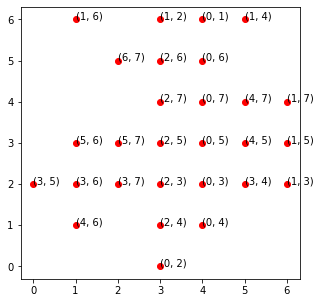

In [181]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
# mc.apply('grow_core', 100)
for coord, qbit in final_core_coords_qbits.items():
#     if qbit in max_core_qbits:
#         color = 'red'
#     else:
#         color = 'green'
    ax.annotate(qbit, coord)
    ax.scatter(*coord, color='red')

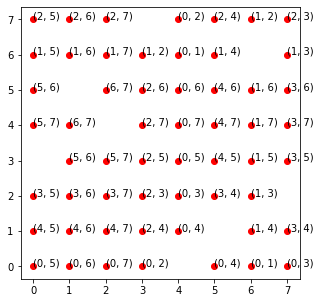

In [201]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
# mc.apply('grow_core', 100)
for coord, qbit in core_coords_qbits.items():
#     if qbit in max_core_qbits:
#         color = 'red'
#     else:
#         color = 'green'
    ax.annotate(qbit, coord)
    ax.scatter(*coord, color='red')

In [202]:
(graph.K - len(final_core_coords_qbits))

0

In [204]:
graph.C - len(plaqs)

-26

In [211]:
core_qbit_coord_dict = {q:c for c,q in final_core_coords_qbits.items()}
polygon_object = Polygons(logical_graph=graph, core_qbit_coord_dict=core_qbit_coord_dict)

In [213]:
energy_object = Energy(polygon_object=polygon_object)

In [214]:
mc = MC(energy_object=energy_object)

In [215]:
# #mc.temperature()
# for i in range(1000):
#     mc.apply("grow_core", 5)

<AxesSubplot:>

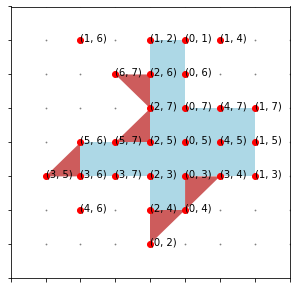

In [216]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
mc.polygon.visualize(ax, polygon_coords=mc.polygon.get_all_polygon_coords())

In [218]:
polygon_object.U
raise AttributeError('dan')

AttributeError: 'Polygons' object has no attribute 'U'